In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import json
from sklearn.calibration import calibration_curve

# set seed biar konssisten hasilnya
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_clean.csv'

if os.path.exists(csv_path):
    print(f"File ditemukan: {csv_path}")
    clean_df = pd.read_csv(csv_path)
else:
    raise FileNotFoundError(f"File tidak ditemukan di: {csv_path}")

# spliting data
feature_cols = [c for c in clean_df.columns if c != "Label"]
X_all = clean_df[feature_cols].astype("float32").values
y_original = clean_df["Label"].values
print("Total sampel:", len(y_original))

print("\n--- Melakukan Split Data (70% Train, 15% Val, 15% Test) ---")
# split 1: Train 70% vs Temp 30%
X_train, X_temp, y_train_orig, y_temp_orig = train_test_split(
    X_all, y_original,
    test_size=0.30,
    random_state=SEED,
    stratify=y_original
)
# split 2: Temp dibagi 50/50 -> Val 15%, Test 15%
X_val, X_test, y_val_orig, y_test_orig = train_test_split(
    X_temp, y_temp_orig,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp_orig
)

# Periksa distribusi
print("\n=== TABLE 3: DATASET SPLIT ===")
train_counts = pd.Series(y_train_orig).value_counts()
val_counts = pd.Series(y_val_orig).value_counts()
test_counts = pd.Series(y_test_orig).value_counts()

df_split = pd.DataFrame({
    "Training set": train_counts,
    "Cross-validation set": val_counts,
    "Test set": test_counts
}).fillna(0).astype(int).sort_index()

df_split.loc['Total'] = df_split.sum()
display(df_split)

print(f"\nTotal Data Asli: {len(clean_df)}")
print(f"Total di tabel (sum kolom): {df_split.loc['Total'].sum()}  (harus = total data * 1 per split kolom)")

# konversi ke biner biar sesuai sama libml benign dan serangan
print("\n--- Mengubah ke Binary Label untuk Training (setelah split) ---")
y_train = (y_train_orig != 'BENIGN').astype('int32')
y_val   = (y_val_orig   != 'BENIGN').astype('int32')
y_test  = (y_test_orig  != 'BENIGN').astype('int32')

print("Distribusi binary di train:", np.bincount(y_train))
print("Distribusi binary di val  :", np.bincount(y_val))
print("Distribusi binary di test :", np.bincount(y_test))
# ==========================================
# 11. SIMPAN SPLIT DATA KE FILE JOBLIB
# ==========================================
from joblib import dump

save_path = "/content/drive/MyDrive/CICIDS2017/split_dataset.joblib"

dataset_split = {
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val,
    "X_test": X_test,
    "y_test": y_test,
    "label_original_train": y_train_orig,
    "label_original_val": y_val_orig,
    "label_original_test": y_test_orig,
    "feature_columns": feature_cols
}

dump(dataset_split, save_path)

print(f"\nDataset split berhasil disimpan ke:\n{save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ditemukan: /content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_clean.csv
Total sampel: 2520798

--- Melakukan Split Data (70% Train, 15% Val, 15% Test) ---

=== TABLE 3: DATASET SPLIT ===


,Training set,Cross-validation set,Test set
BENIGN,1466539,314259,314259
Bot,1364,292,292
DDoS,89610,19202,19202
DoS GoldenEye,7200,1543,1543
DoS Hulk,120992,25927,25927
DoS Slowhttptest,3660,784,784
DoS slowloris,3769,808,808
FTP-Patator,4152,889,890
Heartbleed,8,2,1
Infiltration,25,5,6



Total Data Asli: 2520798
Total di tabel (sum kolom): 2520798  (harus = total data * 1 per split kolom)

--- Mengubah ke Binary Label untuk Training (setelah split) ---
Distribusi binary di train: [1466539  298019]
Distribusi binary di val  : [314259  63861]
Distribusi binary di test : [314259  63861]

Dataset split berhasil disimpan ke:
/content/drive/MyDrive/CICIDS2017/split_dataset.joblib


# pre last

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading Data...

Data Loaded Successfully!
X_train shape: (1764525, 43)
y_train shape: (1764525,)
Jumlah Fitur : 43


Model: "cicids_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 43)             │            87 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attack_score (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,088 (62.85 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 87 (352.00 B)

Class weights: {0: 0.6015949797448278, 1: 2.9607515118159915}
Epoch 1/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9050 - auc: 0.9726 - loss: 0.2065 - val_accuracy: 0.9609 - val_auc: 0.9970 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 2/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9651 - auc: 0.9961 - loss: 0.0881 - val_accuracy: 0.9686 - val_auc: 0.9978 - val_loss: 0.0750 - learning_rate: 0.0010
Epoch 3/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9683 - auc: 0.9971 - loss: 0.0752 - val_accuracy: 0.9718 - val_auc: 0.9981 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 4/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9695 - auc: 0.9975 - loss: 0.0698 - val_accuracy: 0.9696 - val_auc: 0.9983 - val_loss: 0.0669 - learning_rate: 0.0010
Epoch 5/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9702 - auc: 0.9976 - loss: 0.0665 - val_accuracy: 0.9778 - val_auc: 0.9982 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 6/

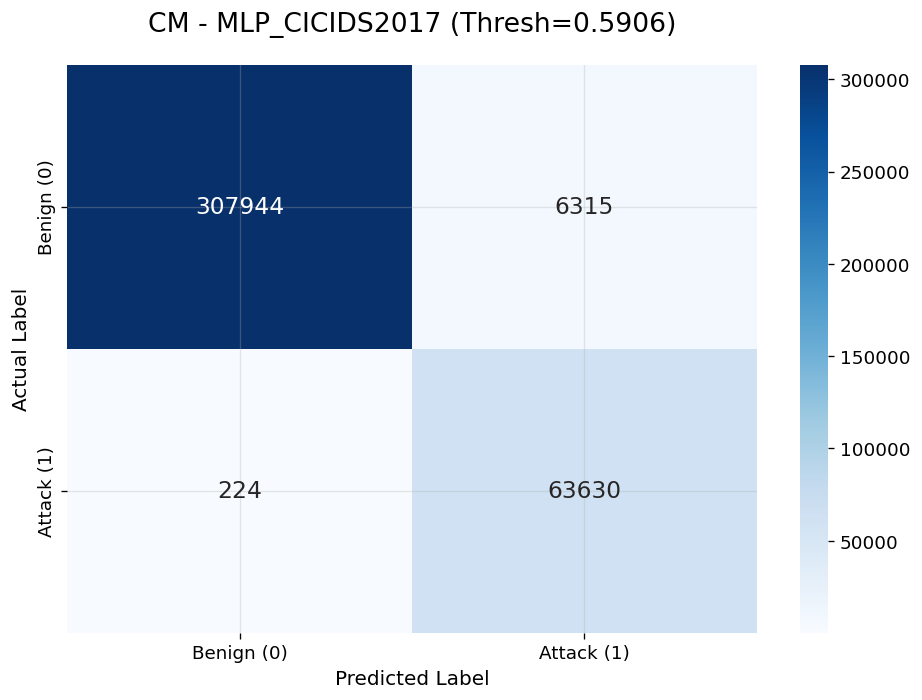

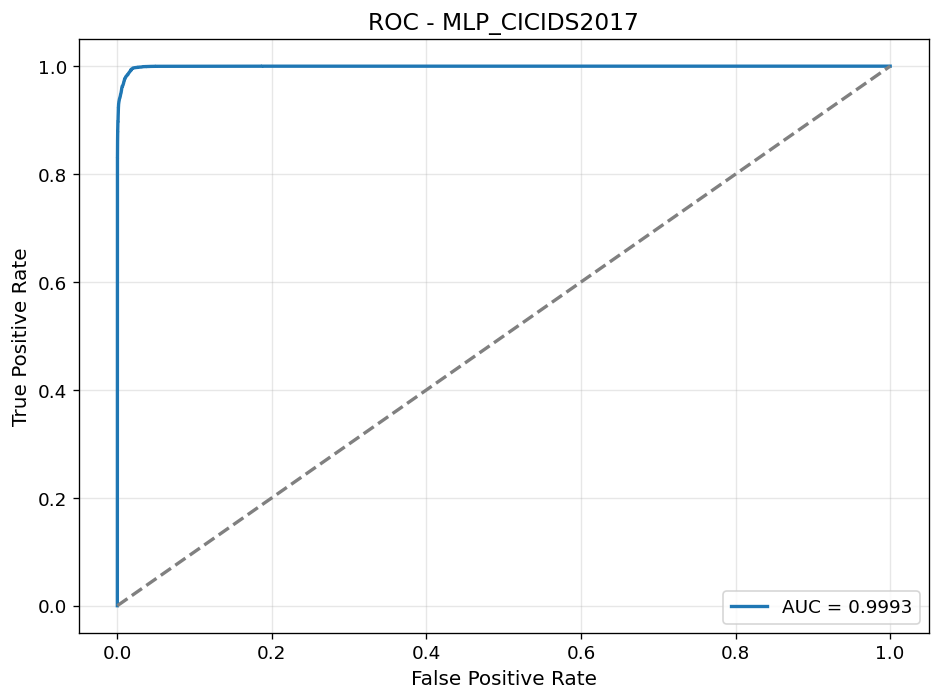

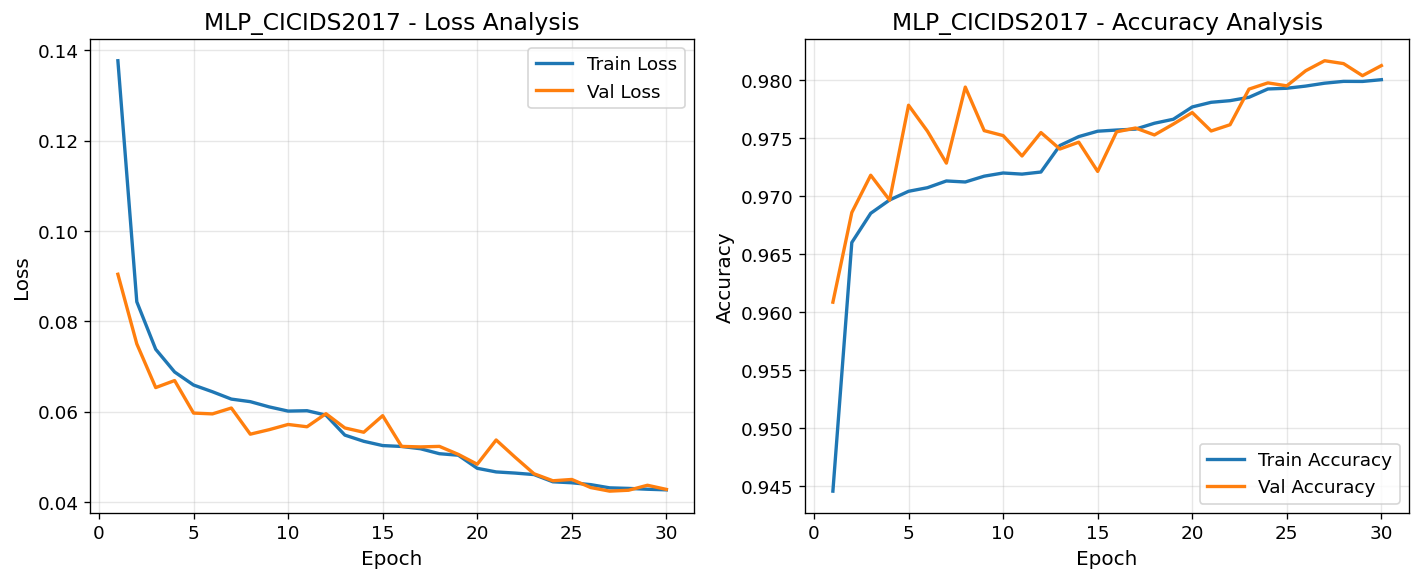


Classification report (threshold=0.5906):
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99    314259
      Attack       0.91      1.00      0.95     63854

    accuracy                           0.98    378113
   macro avg       0.95      0.99      0.97    378113
weighted avg       0.98      0.98      0.98    378113

Saved artifact at '/tmp/tmp83a7x3s8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 43), dtype=tf.float32, name='features')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134426482780752: TensorSpec(shape=(1, 43), dtype=tf.float32, name=None)
  134426482779408: TensorSpec(shape=(1, 43), dtype=tf.float32, name=None)
  134426482781328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134426482780176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134426482783056: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [ ]:
import os
import random
import json
import joblib  # Pastikan import joblib ada
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.calibration import calibration_curve

# ===============================
# 1. HELPER FUNCTIONS & PLOT STYLE
# ===============================

def set_plot_style():
    plt.rcParams.update({
        "figure.figsize": (8, 6),
        "figure.dpi": 120,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "lines.linewidth": 2
    })

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        xticklabels=["Benign (0)", "Attack (1)"],
        yticklabels=["Benign (0)", "Attack (1)"],
        annot_kws={"size": 14}
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color='gray')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

def plot_learning_curve(history, model_name="Model"):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # --- 1. LOSS CURVE ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss Analysis')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- 2. ACCURACY CURVE ---
    if acc:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, label='Train Accuracy')
        if val_acc:
            plt.plot(epochs, val_acc, label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy Analysis')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# [MODIFIED] Helper wrapper yang diperbaiki agar menerima parameter history
def plot_all_evaluation(y_true, y_prob, history, threshold=0.5, model_name="Model"):
    # 1. Konversi probabilitas ke label biner berdasarkan threshold
    y_pred = (y_prob >= threshold).astype(int)

    print(f"\n--- Evaluation for {model_name} (Threshold: {threshold:.4f}) ---")

    # 2. Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, title=f"CM - {model_name} (Thresh={threshold:.4f})")

    # 3. Plot ROC Curve
    plot_roc_curve(y_true, y_prob, title=f"ROC - {model_name}")

    # 4. Plot Learning Curve (Loss & Accuracy)
    if history is not None:
        plot_learning_curve(history, model_name=model_name)
    else:
        print("History object not provided, skipping learning curve.")

# Terapkan style global
set_plot_style()


# ===============================
# 2. MAIN TRAINING PIPELINE
# ===============================

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from google.colab import drive
drive.mount('/content/drive')
print("Loading Data...")
load_path = "/content/drive/MyDrive/CICIDS2017/binary_dataset.joblib"
data = joblib.load(load_path)

# Ekstrak data sesuai key yang kamu tunjukkan di log
# Keys: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'features']
X_train = data['X_train']
y_train = data['y_train']
X_val   = data['X_val']
y_val   = data['y_val']
X_test  = data['X_test']
y_test  = data['y_test']
feature_cols = data['features'] # Ambil nama fitur untuk disimpan nanti

print("\nData Loaded Successfully!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Jumlah Fitur : {len(feature_cols)}")

if hasattr(X_train, 'values'):
    X_train = X_train.values
    X_val = X_val.values
    X_test = X_test.values

# Pastikan tipe data float32
X_train = np.array(X_train, dtype='float32')
X_val   = np.array(X_val, dtype='float32')
X_test  = np.array(X_test, dtype='float32')
y_train = np.array(y_train, dtype='int32')
y_val   = np.array(y_val, dtype='int32')
y_test  = np.array(y_test, dtype='int32')

# Normalisasi layer
normalizer = layers.Normalization(axis=-1)
normalizer.build((None, X_train.shape[1]))
normalizer.adapt(X_train)

# --- Model Definition ---
input_dim = X_train.shape[1]
inputs = keras.Input(shape=(input_dim,), dtype="float32", name="features")
x = normalizer(inputs)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="attack_score")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="cicids_mlp")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

model.summary()

# Class Weights
cw_vals = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {int(k): float(v) for k, v in enumerate(cw_vals)}
print("Class weights:", class_weights)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=5, restore_best_weights=True, mode="max"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", factor=0.5, patience=3, mode="max"
    )
]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# ===============================
# 3. EVALUATION USING HELPER
# ===============================

# --- A. Cari Threshold Terbaik (Youden Index) ---
print("\nSearching for Best Threshold using Validation Set...")
y_val_proba = model.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
youden = tpr - fpr
best_threshold = thresholds[np.argmax(youden)]
print(f"Best Threshold (Youden): {best_threshold:.4f}")

# --- B. Prediksi Test Set ---
y_test_proba = model.predict(X_test).ravel()

# --- C. Panggil Plot Helper ---
# Helper ini sekarang akan menampilkan Confusion Matrix, ROC, dan Learning Curve sekaligus
plot_all_evaluation(
    y_true=y_test,
    y_prob=y_test_proba,
    history=history,          # Masukkan object history training di sini
    threshold=best_threshold,
    model_name="MLP_CICIDS2017"
)

# --- D. Print Report Text ---
y_pred_final = (y_test_proba >= best_threshold).astype(int)
print(f"\nClassification report (threshold={best_threshold:.4f}):")
print(classification_report(y_test, y_pred_final, target_names=['Benign','Attack']))


# ===============================
# 4. SAVING ARTIFACTS
# ===============================
base_dir = "/content/drive/MyDrive/startMLP/MLP_Last_2"
os.makedirs(base_dir, exist_ok=True)

# Simpan Threshold & Features
with open(os.path.join(base_dir, "threshold.json"), "w") as f:
    json.dump({"threshold": float(best_threshold)}, f, indent=4)

with open(os.path.join(base_dir, "feature_cols.json"), "w") as f:
    json.dump(feature_cols, f, indent=4)

# Simpan TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

out_path = os.path.join(base_dir, "cicids_mlp_float32.tflite")
with open(out_path, "wb") as f:
    f.write(tflite_model)

print(f"\nSaved artifacts to: {base_dir}")